<a href="https://colab.research.google.com/github/weymouth/MarineHydro/blob/master/notebooks/wave_greens_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical potential flow water waves 🌊

The goal of this notebook is to compute the potential flow and forces on a body in waves, but let's start with a recap. [In the first notebook](https://github.com/weymouth/MarineHydro/blob/master/notebooks/panel_method.ipynb) we developed a numerical panel method to compute the potential flow around any submerged 2D geometry using source panels. We also developed code to plot the flow and compute the added mass forces.

The functions from that notebook are in [this source file](https://github.com/weymouth/MarineHydro/blob/master/src/PanelMethod.py) which we can execute in this notebook using the [requests package](https://anaconda.org/anaconda/requests)

In [1]:
import requests
url = 'https://raw.githubusercontent.com/weymouth/MarineHydro/master/src/PanelMethod.py'
exec(requests.get(url).content)

## Free surface Greens Function💧+👋=🌊

The panel method developed in the first notebook predicts the potential flow induced by a fully submerged 2D shape. However, when an object moves near the free surface it generates waves, and this changes the flow and forces significantly. Despite the huge change to the physical set-up and results, we only need to make a *single modification* to the previous method:

**We need to modify the oscillating source Green's function $G$ to include the potential flow waves which it generates. That's it!**  

Here is new Green's function, taken from [this modern paper](https://www.researchgate.net/profile/Ed-Mackay/publication/344610701_Calculation_of_the_two-dimensional_free_surface_Green_function/links/5f84519f299bf1b53e20e1f2/Calculation-of-the-two-dimensional-free-surface-Green-function.pdf):

$$ G(x,y,x_s,y_s) = \log(r_s)-2\pi \imath e^Z-f(Z) $$

There are three terms:

1. The first term is the **oscillating source** where $r_s^2 = (x-x_s)^2+(y-y_s)^2$ is the square-distance from the point $(x_s,y_s)$ on the segment to a point $(x,y)$ in space, as before.

2. The second term is the **propagating wave** written using complex variables. The standard wave potential is 
$$ \phi = \frac{|\eta|g}{\omega} e^{Ky}\cos(Kx-\omega t+\Phi) $$
where $\omega$ is the oscillation frequency, $|\eta|,\Phi$ are the wave amplitude and phase and $K=\omega^2/g$ is the deep water wave number. In complex variables we have $e^{\imath\theta} = \cos\theta+\imath\sin\theta$, where $\imath=\sqrt{-1}$. Therefore we can write
$$ \phi = \text{Re}\left[|\zeta| e^{K(y+\imath x)}e^{-\imath\omega t}\right] $$
where $|\zeta|$ is a complex amplitude that includes the phase relative to the motion. The wave term in the equation above is a modification of this basic idea defining $Z=K(y+y_s+\imath(x-x_s))$ and scaling the amplitude relative to the oscillating source. 

3. Finally, the last term is a **standing wave** potential that ensures the oscillating souce satisfies the free surface boundary condition
$$ K\phi-\frac{\partial\phi}{\partial y} = 0 \quad\text{on}\quad y=0$$

Let's look at the velocity field induced by a single source panel near the free surface.

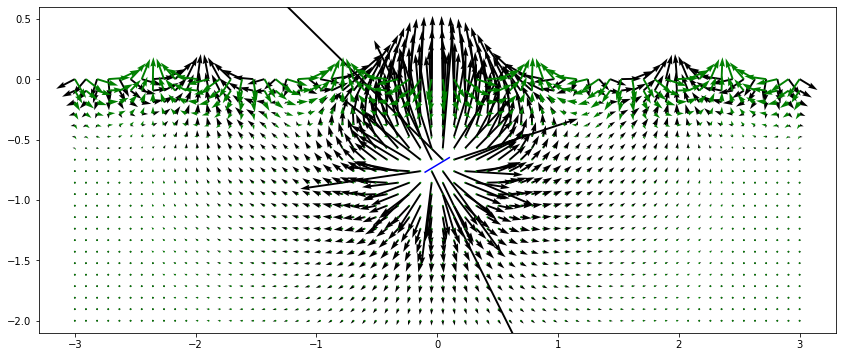

In [2]:
from scipy.special import exp1

def wave_source(x,y,xs,ys,K):
  "Source plus generated free surface waves"
  r2 = (x-xs)**2+(y-ys)**2   # source square-distance
  Z = K*(y+ys+1j*abs(x-xs))  # wave number scaled complex vector
  eZ = np.exp(Z)             # propagating wave potential
  # standing wave potential
  fZ = 2*np.real(eZ*exp1(Z))+np.log(np.abs(Z)/K)
  return 0.5*np.log(r2)-2j*np.pi*eZ-fZ

XY = np.meshgrid(np.linspace(-3,3,66),np.linspace(-2,0,22))
K = 4

plot_flow([-.1,.1],[-.77,-0.65],[1],XY,wave_source,(K,),size=(16,6),ymax=0.6)

The black arrows show the flow velocity in phase with the body velocity (the part with $\sin\omega t$ like before). Now that we have free surface waves, we also have velocity out of phase with the body ($\cos\omega t$), shown in the green arrows. 

This is easier to understand using a movie!

> **Note:** It takes a while for Python to generate the videos, so I've commented those lines out. Uncomment and play around with the flows in the following cells as much as you like.

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def wave_video(x,y,q,XY,G=wave_source,args=(4,),size=(16,6)):
  # Get complex velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))

  # Plot flow and segments
  fig, ax = plt.subplots(1,1,figsize=size)
  Q = ax.quiver(*XY, *UV)#, pivot='mid')
  ax.plot(x,y,c='b')
  ax.set_ylim(None,0.5)
  ax.set_aspect('equal', adjustable='box')
  plt.close()

  # run through a wave period
  def update_quiver(num, Q):
      Q.set_UVC(*np.real(UV*np.exp(-2j*np.pi*num/101)))
      return Q,

  # create the animation
  return FuncAnimation(fig, update_quiver, fargs=(Q,), interval=50)

# anim = wave_video([-.1,.1],[-.77,-0.65],[1],XY)
# HTML(anim.to_html5_video())

[![Link to video](http://i3.ytimg.com/vi/3DSdek0stHM/hqdefault.jpg)](https://youtu.be/3DSdek0stHM)

Looks good. The source, standing wave above it, and the radiating waves on either side are all visible. 

> **Note:** Now that you've seen the video, go back and look at the plot above. The black and green arrows are like snapshots of the video at the start and quarter of the way through a cycle. While the movie is certainly easier to digest, it's important to realize the complex amplitude $|\phi_k|$ has all the information needed to make the movie.

---

## Solving for free surface potential flows and forces 🛥

> **Note:** The plots above use the original `velocity` function, they just apply the new `wave_source` singularity instead of the `source` singularity. Similarly, the `potential` `construct_A` and `added_mass` functions can all by applied to free surface flows without modification!

This is why writing re-usable functions is so powerful. Let's use our new Green's function to produce the flow around a semi-circular ship section in sway.

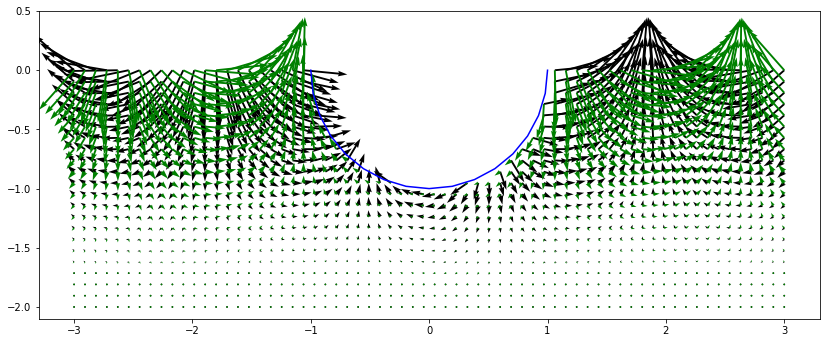

In [4]:
x,y = ellipse(16,theta1=0)
circleXY = mask_grid(*XY,mask=lambda x,y: x**2+y**2<1)
K=2
A,nx,ny = construct_A(x,y,wave_source,(K,))
plot_flow(x,y,np.linalg.solve(A,nx),circleXY,wave_source,(K,),size=(14,6),ymax=0.5)
# anim = wave_video(x,y,q,circleXY,wave_source,(K,))
# HTML(anim.to_html5_video())

That's amazing! You can clearly see the waves radiating away from the ship hull in either direction. When the ship moves to port, it forms a new crest on the port side, and vice-versa!

Now let's check the added mass:

In [5]:
ma = added_mass(x,y,wave_source,(K,))
print(np.array_str(ma, precision=3, suppress_small=True))

[[ 0.289+0.626j -0.   -0.j   ]
 [-0.   -0.j     1.109+0.232j]]


Look carefully at this result because two important things have changed since we moved into free surface flows
1. **The "added mass" has a real and complex part!** This is because some of the force is in-phase with acceleration (like before) and some is in-phase with velocity. The first part is the sectional added mass $A_{kl}$ and the second part is the wave damping $B_{kl}$. The damping is due to the energy leaving the system in the radiating waves, which is why the damping is zero when there is no free surface. 
1. **The added mass and damping depend on the motion direction and wave number!** A fully submerged circle of radius $R$ has $m_{kk}=\rho \pi R^2$ independant of the oscillation frequency or direction. But the standing and radiating waves must satisfy the free surface boundary condition, which depends on $K$, and their amplitude and phase depends on the direction of motion $k$. Therefore the added mass and damping matrices are functions of $K$ and $k$ as well.

Let's plot these coefficients for a range of dimensionless frequencies $\omega \sqrt{R/g}$

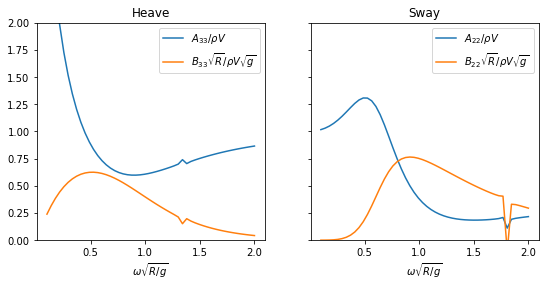

In [6]:
def force_plots(y,z,omega,rhoV=0.5*np.pi):
  @np.vectorize
  def force_coeffs(omega):
    ma = added_mass(y,z,wave_source,(omega**2,))
    return (np.real(ma[0,0])/rhoV,omega*np.imag(ma[0,0])/rhoV, #22
            np.real(ma[1,1])/rhoV,omega*np.imag(ma[1,1])/rhoV) #33

  A22,B22,A33,B33 = force_coeffs(omega)

  f, (hplt,splt) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
  plt.ylim(0,2)
  hplt.set_title('Heave')
  hplt.plot(omega,A33,'C0',label=r'$A_{33}/\rho V$')
  hplt.plot(omega,B33,'C1',label=r'$B_{33}\sqrt{R}/\rho V\sqrt{g}$')
  splt.set_title('Sway')
  splt.plot(omega,A22,'C0',label=r'$A_{22}/\rho V$')
  splt.plot(omega,B22,'C1',label=r'$B_{22}\sqrt{R}/\rho V\sqrt{g}$')
  for ax in (hplt,splt):
    ax.set_xlabel(r'$\omega\sqrt{R/g}$');ax.legend()

omega = np.linspace(0.1,2)
y,z = ellipse(64,theta1=0)
force_plots(y,z,omega)

> **Note:** We've switched to a section in the $y,z$ plane, since this is standard for strip theory. This doesn't change *anything* in the `added_mass` or `wave_source` functions - we simply pass $y,z$ coordinates in and get sway and heave forces out.

Here are some experimental and analytic results for the added mass and damping on a semi-circle from [Vugts 1968](https://content.iospress.com/download/international-shipbuilding-progress/isp15-167-02?id=international-shipbuilding-progress%2Fisp15-167-02). 

| Heave| Sway|
|-|-|
|![heave](https://drive.google.com/uc?export=view&id=1JYMgqOeW_UEGjXzq1VrbZ5_HQXsh3ayI) | ![sway](https://drive.google.com/uc?export=view&id=19P67Q0zPyW_yquO_37lOhHZEFMJlnNiV)|


Our results match the analytic results in the paper really well (other than at two special points that we will discuss in a moment). This validates our free surface force predictions!

The potential flow methods both match the experiments nicely other than the zero frequency heave added mass. Zero frequency heave is not linear - and so linear potential flow can't predict it.

---

## Wave resonance (😄)^💧=😅 

The two blips in our added mass prediction results are due to resonance *inside* the geometry!

> **Note:** These are the frequencies which could potentially cause issues with sloshing cargo.

The flow *inside* the hull is plotted below - showing an internal standing wave. This wave totally dominates the flow and causes a singularity in the added mass calculation. However, we're typically only interested in the forces caused by the flow external to the hull, meaning we can ignore these artifacts.

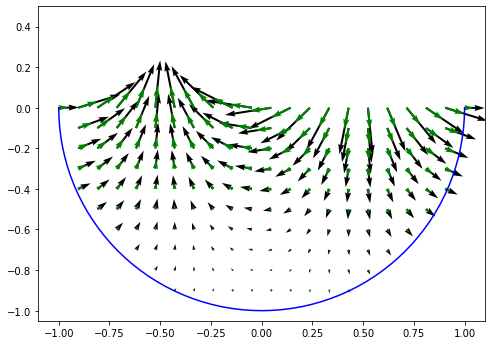

In [7]:
K = 3.25 # sway sloshing wavenumber from plot above
A,ny,nz = construct_A(y,z,wave_source,(K,))
YZ = np.meshgrid(np.linspace(-1,1,22),np.linspace(-1,0,11))
inside = mask_grid(*YZ,mask=lambda y,z: y**2+z**2>1)
plot_flow(y,z,np.linalg.solve(A,ny),inside,wave_source,(K,),size=(8,6),ymax=0.5)
# anim = wave_video(y,z,q,inside,wave_source,(K,),size=(8,6))
# HTML(anim.to_html5_video())

---

## Multiple geometries ⛵⛵

The functions above only compute the flow and forces around a single shape - they take in **one** `x,y` array pair. How can we compute the flow induced by more than one shape, like a multi-hull ship? Here are some ideas:

1. *Superposition:* Can we define the geometries, solve for each flow separately, and then add the flow and forces together? 

No. If we solve for the flows separately, we will miss the influence of the bodies on each other. When we add them up, the body BC won't be satisfied and so the flow and forces will be wrong.

2. *Concatenation:* Can we stack all the body arrays together, and then solve for the flow?

This approach includes the influence of each body on the other, but it will also create fake panels linking the bodies together. We need to zero the influence of those non-panels to use this approach - as I've done below.

3. *Images:* Can we apply the method of images to reflect the geometry across the $y$ axis?

Yes, and this is the classic approach (since it play nice with analytic models) but there are some caveats. Importantly, this only works when you have a plane of symmetry! So you can't use this to model two independent boats - even if the hulls are identical, their motions won't be. 

Sway added mass = 1.12+0.579j


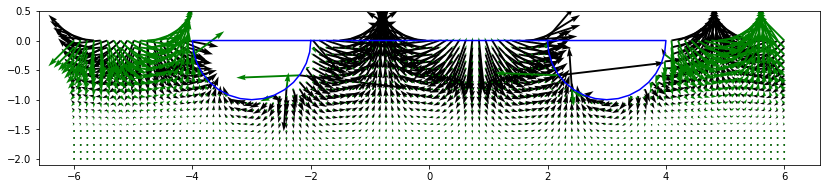

In [8]:
def circle_cat(N,gap):
  ya,za = ellipse(N//2,theta1=0)
  yb,zb = ellipse(N//2,theta1=0)
  return np.append(ya+gap,yb-gap),np.append(za,zb),[N//2]

def concat_sway(y,z,blank,G,args):
    yc,zc,ny,_,h = properties(y[:-1], z[:-1], y[1:], z[1:])
    A,ny,_ = construct_A(y,z,G,args)
    # *blank* out the connecting panels before solving
    for i in blank:
      A[i,:] = np.zeros(len(ny))
      A[i,i] = 1
      ny[i] = 0
    qy = np.linalg.solve(A,ny) # sway source

    B = [h*potential(yc,zc,y[i],z[i],y[i+1],z[i+1],G,args) for i in range(len(yc))]
    myy = -ny@B@qy             # sway added-mass
    return qy,myy

N,K,gap = 32,2,3
y,z,blank = circle_cat(N,gap)
catYZ = np.meshgrid(np.linspace(-6,6,108),np.linspace(-2,0,18))
catYZ = mask_grid(*catYZ,mask=lambda y,z: (abs(y)-gap)**2+z**2<1)
qy,myy = concat_sway(y,z,blank,wave_source,(K,))
print(f'Sway added mass = {myy:.3g}')
plot_flow(y,z,qy,catYZ,wave_source,(K,),size=(14,6),ymax=0.5)

Look at the wave in the center of the plot, between the two circles. Since the arrows are all black instead of green, this is a standing wave caught between the hulls. As with the *internal* wave mentioned above, this *external* standing wave will also produce large forces and we therefore need to be careful to consider it's impact on multi-hull performance. 

---

## Parametric study 🧑‍💻 📈

We will run a geometric parameter sweep on the distance between the centers $Y$=2`gap` to investigate the impact of the geometry and on the forces.

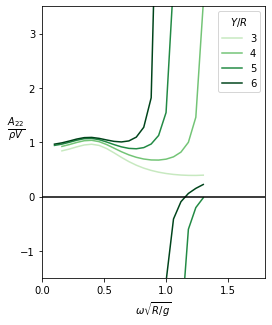

In [9]:
def cat_sway_added_mass(gap,omega,rhoV=np.pi):
  @np.vectorize
  def omega_sweep(omega):
    y,z,blank = circle_cat(32,gap)
    _,ma = concat_sway(y,z,blank,wave_source,(omega**2,))
    return np.real(ma/rhoV)
  return omega_sweep(omega)

def myplot(x,y,label,**kwargs): # remove segment connecting +/- singularities
  i = np.argmax(np.diff(y)<-4)+1
  plt.plot(x[:i],y[:i],label=label,**kwargs)
  plt.plot(x[i:],y[i:],**kwargs)

omega = np.linspace(0.1,1.3,21)
plt.figure(figsize=(4,5))
for Y in range(3,7):
  myplot(omega,cat_sway_added_mass(Y/2,omega),label=Y,color=plt.cm.Greens((Y-2)/4))
plt.legend(title=r'$Y/R$')
plt.axhline(y=0,c='k'); plt.xlabel(r'$\omega\sqrt{R/g}$')
plt.ylabel(r'$\frac{A_{22}}{\rho V}$',rotation=0,size=14)
plt.ylim(-1.5,3.5); plt.xlim(0,1.8);

This plot (formatted to match the figure in Faltisen) shows that the resonant standing wave between the hulls causes a singularity in the linear added-mass. As before, the singularity indicates a breakdown of linear theory but these points are still important for the dynamics of the cat:

 1. The added mass skyrockets to extremely large values as the frequency approaches the resonant frequency from the left, indicating that oscillating the cat requires accelerating a huge amount of fluid. As the frequency is crossed, the sign of the added-mass flips to negative, indicating that the fluid is now driving the cat oscillates instead of being driven! 
 2. The resonant frequency decreases as the gap is increased, corresponding to the longer wavelength of the standing wave. Building a cat with a spacing similar to the dominant water wavelength in a region would lead to serious seakeeping and stability issues.

---


## Summary 🏁 🏁

That's it for the second notebook. Let's review the main takeaway points:
 1. To solve for potential flows with a free surface, we **only** need to modify the Green's function to include the surface wave potential induced by the source. No other changes are needed to any of the functions from the previous notebook!
 2. The wave potential, and therefore the flow solutions and forces, inherently **depends on the oscillation frequency** because of the free surface boundary conditions. 
 3. In addition to the added-mass force in phase with body acceleration, there is also a **wave damping force** in phase with the body velocity which carries energy away from the body.
 4. The forces may vary drastically with frequency, particularly near resonance. The most extreme cases being the occurance of internal or external **standing waves**.
 5. A **parameteric study** sweeps over one or more nondimensional parameters of interest such as a geometric ratio, and can provide important insights into a marine design. 